## Estimating the number of BEVs in any particular location

We're going to use Cambridge as our example place. This is defined as any place that has a CB postcode. 

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from google.cloud import bigquery

# Progress bars are helpful for big data
import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

Our data are spread across a few databases. Let's start by importing all of the tests that were carried out in a CB postcode. 

Using a bigquery magic. My environment contains a variable with my authentication details. 

In [2]:
%load_ext google.cloud.bigquery

In [3]:
%%bigquery df_camb --project rugged-baton-283921 
WITH camb_test_nos as (
    SELECT test_cert_number
    FROM `rugged-baton-283921.location.test_locations`
    WHERE outer_postcode LIKE "CB%"
    AND test_completed > '2020-02-28'
    AND test_completed < '2021-03-01'
), camb_tests as (
    SELECT A.*
    FROM `rugged-baton-283921.mots_uk.tests` A 
    INNER JOIN camb_test_nos B
    on A.motTestNumber = CAST(B.test_cert_number AS STRING)
), camb_vehs_tests as (
    SELECT 
        A.completedDate,
        A.odometerValue,
        A.odometerUnit,
        A.registration,
        B.make,
        B.model
    FROM camb_tests A
    INNER JOIN mots_uk.vehicles B
    ON A.registration = B.registration
    WHERE A.testResult = 'PASSED'
), camb_vehs_mot_ves as (
    SELECT 
        A.completedDate,
        A.odometervalue,
        A.odometerUnit,
        A.registration,
        A.make,
        A.model,
        B.fuelType,
        B.monthOfFirstRegistration
    FROM camb_vehs_tests A
    INNER JOIN `rugged-baton-283921.VES_dataset.VRN_All` B
    ON A.registration = B.registrationNumber
)

SELECT 
    monthOfFirstRegistration,
    fuelType,
    COUNT (DISTINCT registration) as numb
FROM camb_vehs_mot_ves
GROUP BY monthOfFirstRegistration, fuelType;

Downloading: 100%|█████████████████████████████████████████████████████████████| 1581/1581 [00:01<00:00, 1526.68rows/s]


In [4]:
df_camb['monthOfFirstRegistration'] = df_camb['monthOfFirstRegistration'].apply(lambda x: pd.to_datetime(x))

In [5]:
df_camb = df_camb[df_camb['fuelType'].isin(['HYBRID ELECTRIC', 'DIESEL', 'PETROL', 'ELECTRICITY'])]

In [6]:
df_camb = df_camb[df_camb['monthOfFirstRegistration'] > '2000-01-01']
df_camb = df_camb[df_camb['monthOfFirstRegistration'] < '2017-07-01']

In [7]:
df_camb['year'] = df_camb['monthOfFirstRegistration'].apply(lambda x: x.year)

In [8]:
df_camb.dtypes

monthOfFirstRegistration    datetime64[ns]
fuelType                            object
numb                                 int64
year                                 int64
dtype: object

<AxesSubplot:xlabel='year', ylabel='numb'>

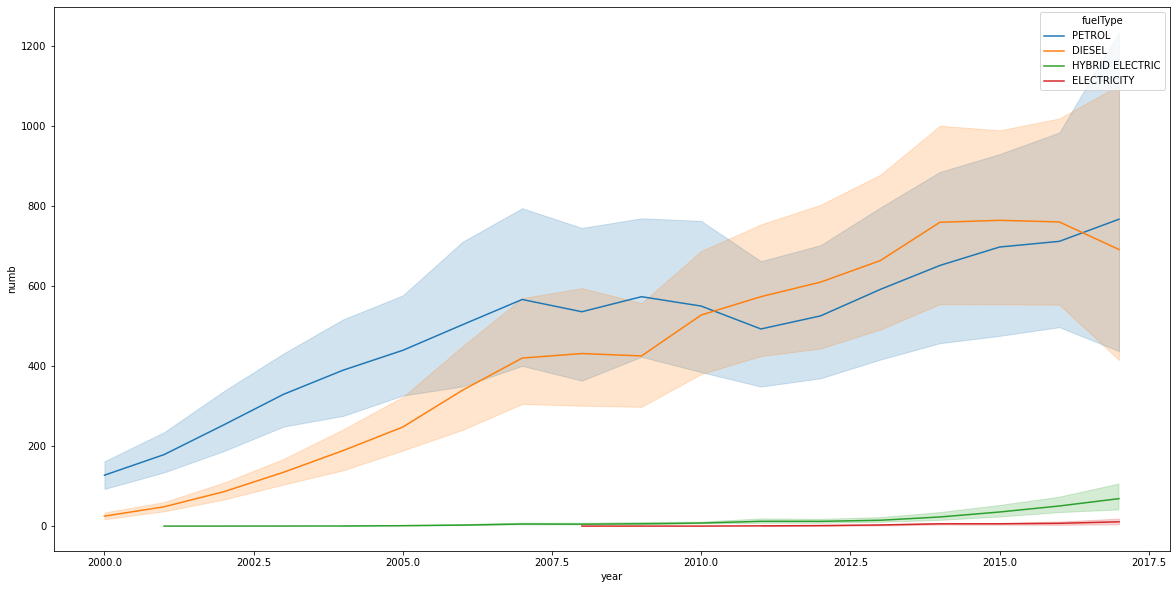

In [9]:
plt.figure(figsize=(20, 10))
sns.lineplot(data = df_camb, x='year', y='numb', hue='fuelType')

<AxesSubplot:xlabel='year', ylabel='numb'>

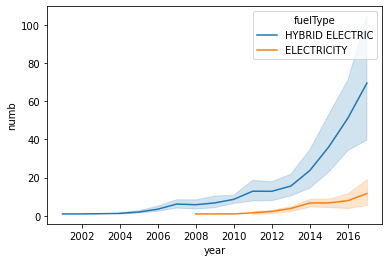

In [10]:
sns.lineplot(data = df_camb[df_camb['fuelType'].isin(['ELECTRICITY', 'HYBRID ELECTRIC'])], x='year', y='numb', hue='fuelType')

In [11]:
df_camb.head()

,monthOfFirstRegistration,fuelType,numb,year
0,2001-01-01,PETROL,139,2001
1,2001-08-01,PETROL,77,2001
2,2003-07-01,PETROL,330,2003
3,2004-07-01,PETROL,407,2004
4,2007-03-01,DIESEL,894,2007


In [12]:
%%bigquery df_east --project rugged-baton-283921 
SELECT monthOfFirstRegistration, fuelType, COUNT(*) as numb
FROM `rugged-baton-283921.VES_dataset.VRN_All`
WHERE registrationNumber LIKE "A%"
GROUP BY monthOfFirstRegistration, fuelType

Downloading: 100%|█████████████████████████████████████████████████████████████| 2935/2935 [00:00<00:00, 3141.06rows/s]


In [13]:
df_east['monthOfFirstRegistration'] = df_east['monthOfFirstRegistration'].apply(lambda x: pd.to_datetime(x))
df_east = df_east[df_east['monthOfFirstRegistration'] > '2000-01-01']

In [14]:
df_east['year'] = df_east['monthOfFirstRegistration'].apply(lambda x: x.year)

In [15]:
df_east = df_east[df_east['fuelType'].isin(['HYBRID ELECTRIC', 'DIESEL', 'PETROL', 'ELECTRICITY'])]

In [16]:
df_east.head()

,monthOfFirstRegistration,fuelType,numb,year
0,2020-05-01,DIESEL,530,2020
1,2020-05-01,PETROL,799,2020
2,2020-05-01,HYBRID ELECTRIC,57,2020
3,2020-04-01,DIESEL,261,2020
4,2021-04-01,PETROL,40,2021


<AxesSubplot:xlabel='year', ylabel='numb'>

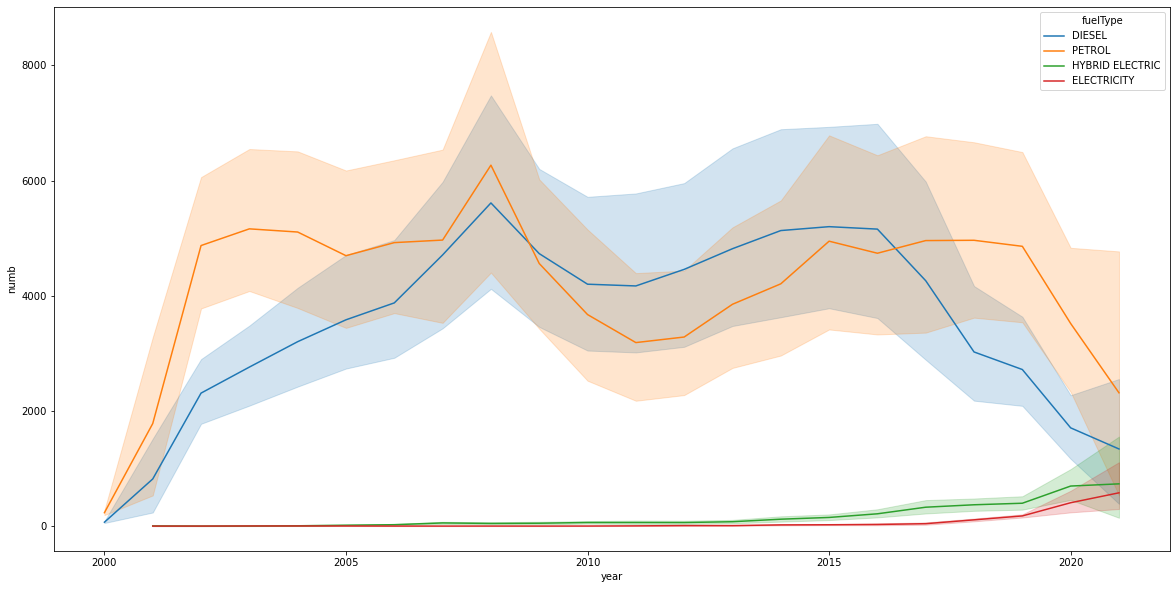

In [17]:
plt.figure(figsize=(20, 10))
sns.lineplot(data = df_east, x='year', y='numb', hue='fuelType')

Ok we now have two datasets. 

We have `df_camb`, which has the number of vehicle registrations in Cambridgeshire up to 2017.
We have `df_east`, which has the number of vehicle registrations in the East of England up until 2021.

Each dataset goes back to 2000-01-01. What we want to do is look for some relationships between them. To create our model, we should make the datasets cover precisely the same time period, before splitting into test, train, and validation sets. If our model works, we can come back and make a prediction for the last three years.

In [18]:
# we'll save a full copy of df_east as df_east_complete
df_east_complete = df_east.copy()

In [19]:
#Now make it the same length as df_camb
df_east = df_east[df_east['monthOfFirstRegistration'] > '2000-01-01']
df_east = df_east[df_east['monthOfFirstRegistration'] < '2017-07-01']

In [20]:
df_east.drop(columns = 'year', inplace=True)

In [21]:
df_camb.drop(columns='year', inplace=True)

In [22]:
df_east_long = df_east.pivot_table(index='monthOfFirstRegistration', columns='fuelType').reset_index()
# df_east_long.head()

In [23]:
df_camb_long = df_camb.pivot_table(index='monthOfFirstRegistration', columns='fuelType').reset_index()
# df_camb_long.head()

In [24]:
df_east_long.columns = ['reg', 'diesel', 'electricity', 'hybrid', 'petrol']
df_east_long.head()

,reg,diesel,electricity,hybrid,petrol
0,2000-02-01,27.0,NaN,NaN,122.0
1,2000-03-01,91.0,NaN,NaN,369.0
2,2000-04-01,47.0,NaN,NaN,208.0
3,2000-05-01,64.0,NaN,NaN,241.0
4,2000-06-01,85.0,NaN,NaN,278.0


In [25]:
df_camb_long.columns = ['reg', 'diesel', 'electricity', 'hybrid', 'petrol']
df_camb_long.head()

,reg,diesel,electricity,hybrid,petrol
0,2000-02-01,10.0,NaN,NaN,34.0
1,2000-03-01,55.0,NaN,NaN,256.0
2,2000-04-01,21.0,NaN,NaN,112.0
3,2000-05-01,34.0,NaN,NaN,118.0
4,2000-06-01,21.0,NaN,NaN,139.0


They're slightly different shapes. We'll go and and do a full outer join and then interpolate anything that's missing. 

In [26]:
df = pd.merge(left = df_camb_long,
             right = df_east_long,
             how = 'outer',
             on = 'reg',
             suffixes=('_c', '_e'))


In [27]:
df.head()

,reg,diesel_c,electricity_c,hybrid_c,petrol_c,diesel_e,electricity_e,hybrid_e,petrol_e
0,2000-02-01,10.0,NaN,NaN,34.0,27.0,NaN,NaN,122.0
1,2000-03-01,55.0,NaN,NaN,256.0,91.0,NaN,NaN,369.0
2,2000-04-01,21.0,NaN,NaN,112.0,47.0,NaN,NaN,208.0
3,2000-05-01,34.0,NaN,NaN,118.0,64.0,NaN,NaN,241.0
4,2000-06-01,21.0,NaN,NaN,139.0,85.0,NaN,NaN,278.0


### Starting to build a model to predict Cambridge's population of electric vehicles.

Initial steps we need to take:
- Set the datetime column as index,
- Split into test and training data,
- Normalise our data (we normalise everything on the training data, *we never compute anything on the test data*)

In [28]:
df.set_index('reg', drop=True, inplace=True)

In [65]:
df.head()

,diesel_c,electricity_c,hybrid_c,petrol_c,diesel_e,electricity_e,hybrid_e,petrol_e
reg,,,,,,,,
2000-02-01,10.0,NaN,NaN,34.0,27.0,NaN,NaN,122.0
2000-03-01,55.0,NaN,NaN,256.0,91.0,NaN,NaN,369.0
2000-04-01,21.0,NaN,NaN,112.0,47.0,NaN,NaN,208.0
2000-05-01,34.0,NaN,NaN,118.0,64.0,NaN,NaN,241.0
2000-06-01,21.0,NaN,NaN,139.0,85.0,NaN,NaN,278.0


In [66]:
df.fillna(0, inplace=True)

In [67]:
# Not leaving much test data, which is beacuse we don't want to exclude too many years with significant numbers of EV registrations.

train_data = df.loc[:'2017-01-01']
test_data = df.loc['2017-01-01':]

In [68]:
# # Normalise by subtracting the mean and dividing by the std
# mean = train_data.mean(axis=0)
# train_data -= mean
# std = train_data.std(axis=0)
# train_data /= std

# test_data -= mean
# test_data /= std

In [69]:
# Our target is the number of electric vehicles in Cambridgeshire - so we pop that column out and pass it to the 
train_labels = train_data.pop('electricity_c')
test_labels = test_data.pop('electricity_c')

In [70]:
train_data.shape

(204, 7)

In [136]:
from keras import models
from keras import layers

In [148]:
model= models.Sequential()
model.add(layers.Dense(9, activation='relu', input_shape = (train_data.shape[1],)))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [149]:
history = model.fit(x=train_data,
                   y=train_labels,
                   batch_size=128,
                   epochs=200,
                   verbose=0,
                   validation_split=0.2)

<Figure size 432x288 with 0 Axes>

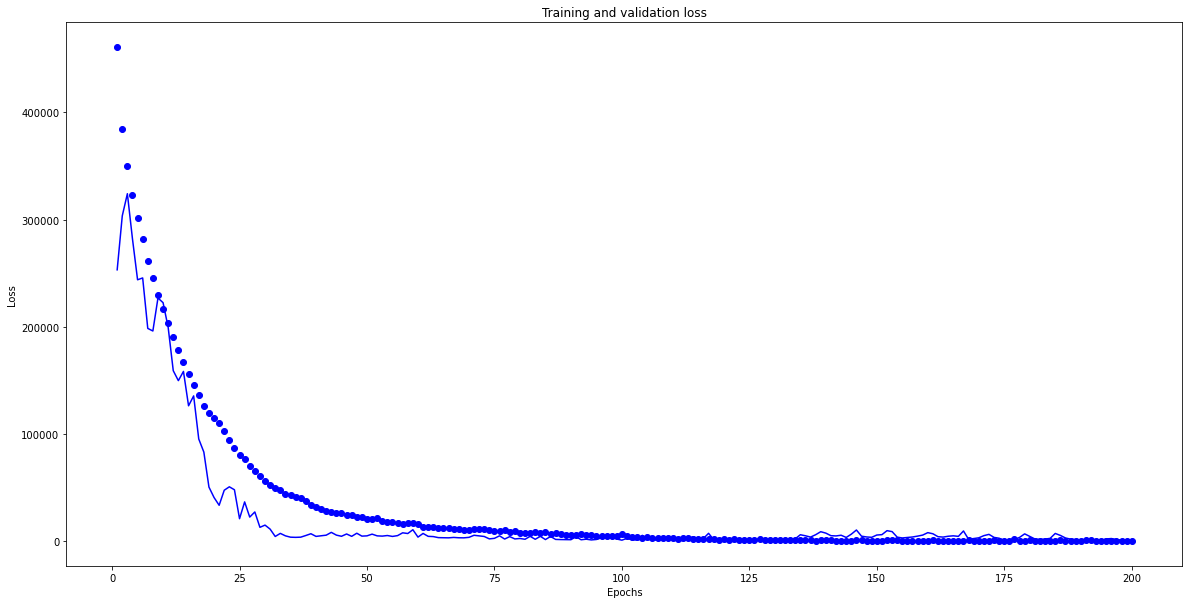

In [150]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.clf()
plt.figure(figsize=(20, 10))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

<Figure size 432x288 with 0 Axes>

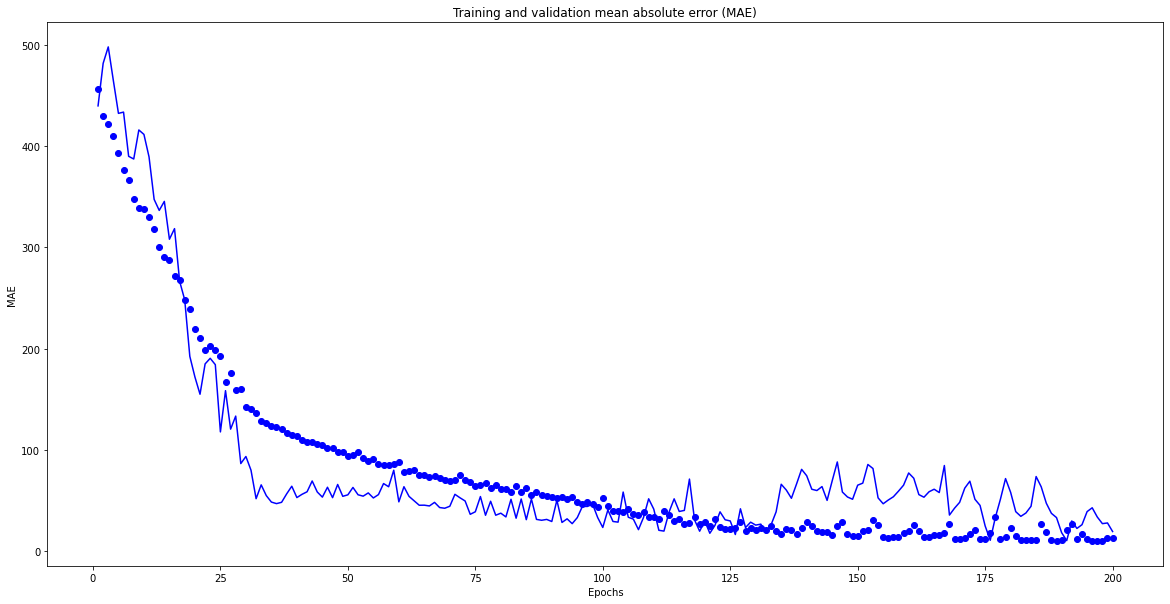

In [151]:
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = range(1, len(mae)+1)

plt.clf()
plt.figure(figsize=(20, 10))
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and validation mean absolute error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

In [152]:
test_mae, test_loss = model.evaluate(test_data, test_labels)

1/1 [==============================] - 0s 11ms/step - loss: 3108.6638 - mae: 50.7708


#### Dealing with little data

Every time we run this, we get wildly different accuracies on the test data. 

We have very little data from which to build our model. That means that validation will be difficult. For that reason, we're going to try to use k-fold validation. That will mitigate the risk that choosing different validation sets will create high levels of variance (which is likely when trying to predict a small part of the market). 

However, as they say: *tra il dire e il fare, c'e' di mezzo il mare*